In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob

In [5]:
def extract_patches(features, targets, patch_size=18):
    """
    Extracts non-overlapping patches of size patch_size x patch_size from the input arrays.
    
    Args:
        features (numpy.ndarray): The feature array of shape (1442, 1021, 15).
        targets (numpy.ndarray): The target array of shape (1442, 1021).
        patch_size (int): The size of the patches to extract.

    Returns:
        X_patches (numpy.ndarray): Extracted patches from features, shape (num_patches, 18, 18, 15).
        y_patches (numpy.ndarray): Extracted patches from targets, shape (num_patches, 18, 18).
    """
    # Crop the arrays to be multiples of 18
    new_x = (features.shape[0] // patch_size) * patch_size
    new_y = (features.shape[1] // patch_size) * patch_size
    
    features = features[:new_x, :new_y, :]
    targets = targets[:new_x, :new_y]

    # Split into patches
    X_patches = []
    y_patches = []
    
    for i in range(0, new_x, patch_size):
        for j in range(0, new_y, patch_size):
            X_patches.append(features[i:i+patch_size, j:j+patch_size, :])
            y_patches.append(targets[i:i+patch_size, j:j+patch_size])

    return np.array(X_patches), np.array(y_patches)

In [6]:
path = "../data/preprocessed_data"

# Get sorted file lists
feature_files = sorted(glob.glob(f"{path}/*_features.npy"))
target_files = sorted(glob.glob(f"{path}/*_targets.npy"))

# Generate indices and shuffle
indices = np.arange(len(feature_files))
np.random.shuffle(indices)

test_idx = indices[0]
remaining_idx = indices[1:]
train_split = int(0.85 * len(remaining_idx))
train_idx = remaining_idx[:train_split]
val_idx = remaining_idx[train_split:]


# Create datasets
train_features = [feature_files[i] for i in train_idx]
train_targets = [target_files[i] for i in train_idx]

val_features = [feature_files[i] for i in val_idx]
val_targets = [target_files[i] for i in val_idx]

test_features = [feature_files[test_idx]]
test_targets = [target_files[test_idx]]

In [18]:
class LazyLoadDataset(tf.data.Dataset):
    def __new__(cls, input_files, target_files, batch_size=1):
        # Convert lists to TensorFlow datasets
        input_ds = tf.data.Dataset.from_tensor_slices(input_files)
        target_ds = tf.data.Dataset.from_tensor_slices(target_files)

        def load_numpy(input_path, target_path):
            x = np.load(input_path.numpy())
            y = np.load(target_path.numpy())
            y = y[:, :, 1]  # Select fco2_pre
            
            # Extract 18x18 patches
            x_patches, y_patches = extract_patches(x, y)
            
            return x_patches, y_patches

        def load_numpy_tf(input_path, target_path):
            x_patches, y_patches = tf.py_function(load_numpy, [input_path, target_path], [tf.float32, tf.float32])
            
            # Set expected shapes
            x_patches.set_shape([None, 18, 18, 15])
            y_patches.set_shape([None, 18, 18])
            
            return x_patches, y_patches

        # Zip the datasets & apply loading function
        dataset = tf.data.Dataset.zip((input_ds, target_ds))
        dataset = dataset.map(load_numpy_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Batch, shuffle, and prefetch
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

        return dataset

In [19]:
batch_size = 2
train_dataset = LazyLoadDataset(train_features, train_targets, batch_size)
val_dataset = LazyLoadDataset(val_features, val_targets)
test_dataset = LazyLoadDataset(test_features, test_targets)

In [ ]:
def build_cnn(input_shape=(18, 18, 15)):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
        x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(1, (3, 3), activation="linear", padding="same")(x)  # Regression output

    model = keras.Model(inputs, x)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    
    return model

# Build and compile model
model = build_cnn()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 18, 18, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 32)     │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 18, 18, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 18, 18, 1)      │         1,153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,857 (382.25 KB)

 Trainable params: 97,857 (382.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=8,  # Number of training epochs
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/8
111/111 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - loss: 24589.4590 - mae: 122.9949 - val_loss: 2734.3853 - val_mae: 32.4408
Epoch 2/8
111/111 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - loss: 2435.9961 - mae: 31.6146 - val_loss: 1064.0753 - val_mae: 19.3959
Epoch 3/8
111/111 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - loss: 1030.8959 - mae: 19.1281 - val_loss: 860.7300 - val_mae: 16.6254
Epoch 4/8
111/111 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - loss: 877.5688 - mae: 17.1165 - val_loss: 784.5569 - val_mae: 15.7460
Epoch 5/8
111/111 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - loss: 775.7355 - mae: 15.8600 - val_loss: 723.7489 - val_mae: 15.0534
Epoch 6/8
111/111 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - loss: 757.4207 - mae: 15.9518 - val_loss: 666.6896 - val_mae: 14.4956
Epoch 7/8
111/111 ━━━━━━━━━━━━━━━━━━━━ 972s 9s/step - loss: 688.9438 - mae: 15.2928 - val_loss: 610.3051 - val_mae: 13.9744
Epoch 8/8
111/111 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - loss: 638.0495 - mae: 14.9047 - val_loss: 557.2650 - val_mae: 13.4448


In [22]:
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step - loss: 537.9490 - mae: 13.6394
Test Loss: 537.9490356445312, Test MAE: 13.639397621154785


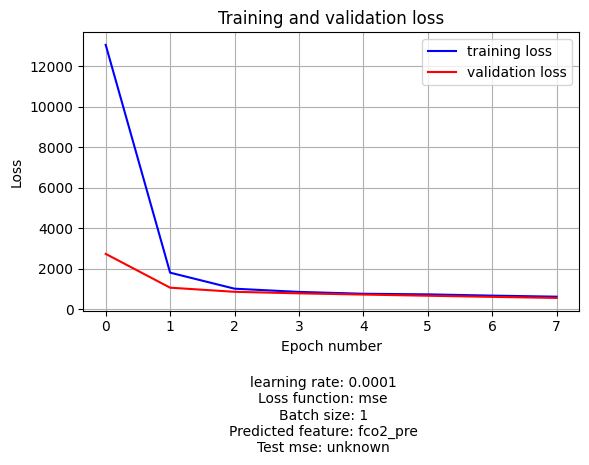

In [23]:
from datetime import datetime
import matplotlib.pyplot as plt

lr = 0.0001
loss_function = 'mse'
batch_size = 1


plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend()

plt.subplots_adjust(bottom=0.3)
plt.figtext(0.5, 0.01, f"learning rate: {lr}\nLoss function: {loss_function}\nBatch size: {str(batch_size)}\nPredicted feature: fco2_pre\nTest mse: unknown",
            wrap=True, horizontalalignment='center', fontsize=10, color='black')

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
path = '../plots/cnn/' + timestamp + '_training_validation_loss.png'
plt.savefig(path, format='png', dpi=300)
plt.show()  